<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_HershU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

Nothing important just necessary for the code to work

In [5]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 703.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [6]:
import preliz as pz
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Who fouls the most in basketball?

## Context

Basketball is a sport where people try to put a ball into a basket. There are two teams and each time wants to get the ball into a different basket. What I'm interested in is how often these teams get physical and illegally contact a player. Holding, pushing, charing into, or impedeing an opponent counts as a personal foul. For example, hugging can be a personal foul. I'm interested in who the villains of basketball are.

What I'm going to be measuring is how often a player commits a personal foul. I'm going to use the minutes a player has played and how many personal fouls they commited in those minutes as my data. I'm also going to group the players by team and by position to try and find some interesting results.

I'm going to base my model on the fact that fouls happen randomly within a given time. I'm then going to try and find the rate at which fouls happen.

## Assumptions

**My main assumption is that the chance of a player commiting a certain amount of fouls can be modelled by a Poisson distribution. A Poisson distribution models how many times an event happens in a certain time period with a constant rate. This exactly fits my scenario except two personal fouls can't happen at almost the same time and the rate for players isn't fully constant. I'm assuming though that these two things don't change the scenario too much and personal fouls still follow a Poisson distribution.**

Other than that, the rest of my assumptions are reasonably small.


I think there might be a good bit or variability between players. Some are likely more prone to fouling than others. I'm going to assume this is an actual trend and I will use priors with a good bit of variability.

I also think it's a reasonable assumption to make that the average rate at which players commit personal fouls is once every 12 minutes (so 1 foul / 12 minutes). This would be about 1 personal foul if a player plays for one quarter (12 minutes) a game. I don't watch or know too much basketball but this seems reasonable to me, especially if I use a semi-larger variance. I'm going to assume means of around (1/12) with my priors. (Note that I will talk about rates in minutes/foul since it's easier to understand but all my units are in foul/minutes. No skew in foul/minutes would mean skew in minutes/foul)

I'm unsure of how any skew would exist for the distribution of rates of players so I'm going to assume no skew.

I think the general shape of the distribution of probabilities of fouling at certain rates will be somewhat of a bell-curve. There is going to be one most likely rate and then chances will slowly diffuse as the rates get higher and lower. I'm going to use bell-curved distributions for my priors of the likelihood.

I'm also assuming this process is unimodal. This may not be the case, but I still think it's a reasonable assumption to make. I'm also removing some of the possible modes by splitting players into teams or positions.

I'm going to assume the means are dependent. The mean should be around the same for all the teams and positions, though I would expect high variability between positions.

I'm also going to assume skew and variance (of the means) are independent between positions but dependent between teams. Certain positions may require to get more physical than others so they may commit more fouls (than other positions, so the difference between them is high). I'm assuming there wouldn't be too much difference between teams since they should all have the same general positions and play styles. This is a big assumption but based on my knowledge it should be ok. Like everything I'll keep it variable.

## Priors

I know I'm going to be using a poisson distribution for one of my models so coming up with a prior for the actual rate will be fine. The first prior will be my most base level prior which will be the player prior.

I'm going to use a (truncated) normal distribution for my prior on the mean of the rates for positions and teams since it meets all my assumptions. I can make its mean 1/12, and I can give a high variance to show my uncertainty, it is somewhat bell-curved, and it has no skew.



<Axes: >

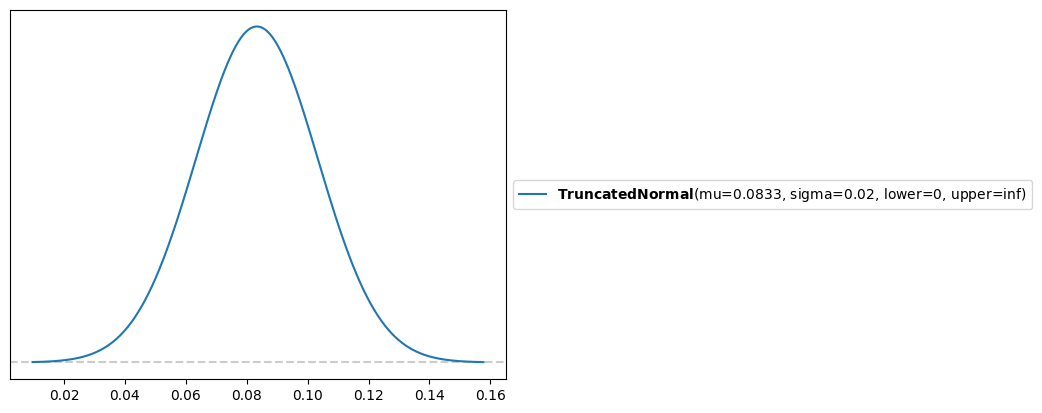

In [ ]:
playerPrior = pz.TruncatedNormal(mu = 1/12, sigma = .02, lower=0, upper = np.inf) # I fiddled with these numbers to find ones that worked. The 68% range for rates is 9.7 - 15.8 minutes for one foul (but units are foul/minutes, so less than 1)
playerPrior.plot_pdf()

**Now it's time for my position/team priors.**

These priors will be priors for the parameters of the player priors. The two options are then position/team priors for mu and position/team priors for sigma. I'm assuming that positions/teams affect the rate but not the variability of the rate.

My prior will then be a normal distribution. I can keep the mean of mu the same and it allows for a large variation. Again, I'm not too knowledgeable here so I'm assuming no skew.

<Axes: >

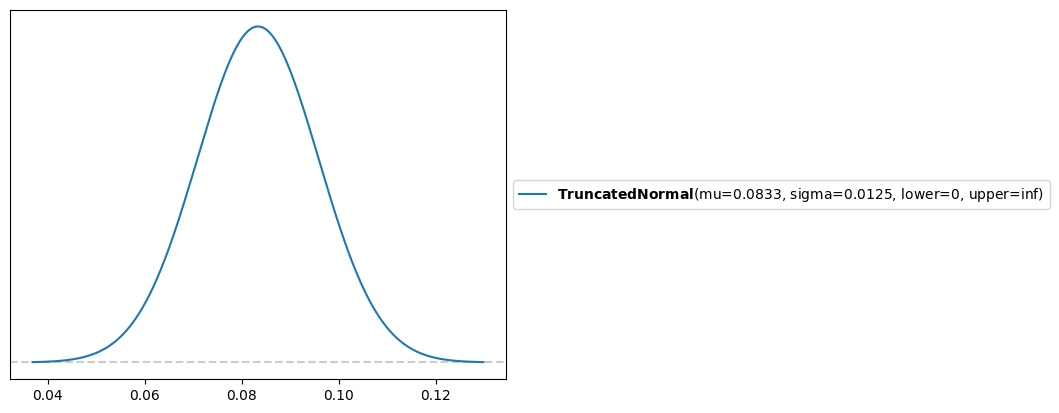

In [ ]:
teamPrior = pz.TruncatedNormal(mu=1/12, sigma = .0175, lower = 0, upper = np.inf) # lower sigma since less variation between teams than players (means less variable)
teamPrior.plot_pdf()

The distibution is the same except I'm more certain the means to teams/positions will be close to 1/12. The variance is still very large (20 minutes per foul to 9 minutes per foul).

**Hyperpriors!**

My hyperpriors now must be either for mu or sigma of the previos normal distribution. Based on my assumptions, I'll need a hyperprior for for mu and a hyperprior for sigma for only teams.

My hyperprior for mu will also be a normal distribution. I can set the mean to 1/12 and I can set a reasonably high variance. I don't think there is any skew so a normal distribution works.

My hyperprior for sigma will also be a normal distribution. I have no clue what's going on with sigma so I'm just showing my uncertainty around a mean value with a normal distribution. The mean will be .0175 and variance will be .004.

<Axes: >

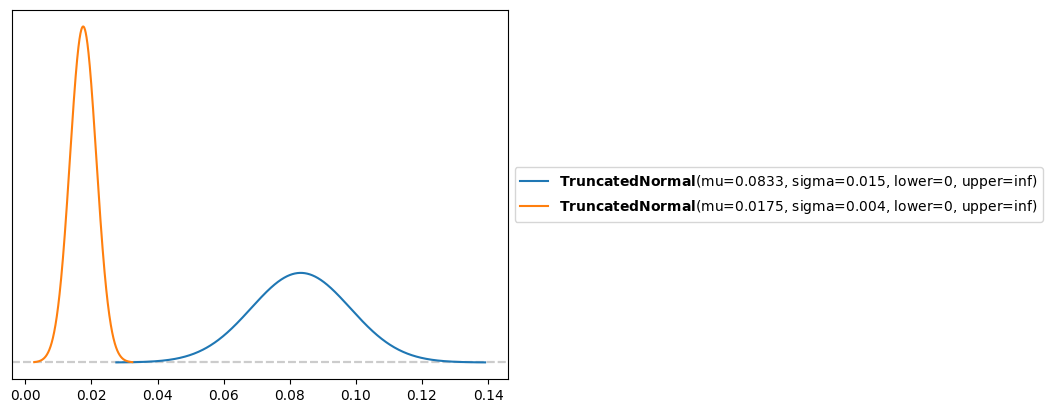

In [ ]:
muHyperPrior = pz.TruncatedNormal(mu=1/12, sigma = .015, lower = 0, upper = np.inf) # slow decreasing sigma because the mean of the population is more certain
sigmaHyperPrior = pz.TruncatedNormal(mu=.0175, sigma = .003, lower = 0, upper = np.inf)
muHyperPrior.plot_pdf()
sigmaHyperPrior.plot_pdf()

Matches my assumptions.

## Data!!!

In [7]:
# time to actually get some data

dataLink = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"

basketData = pd.read_csv(dataLink, dtype={'Pos':'category', 'Tm':'category'})

basketData

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [8]:
basketData = basketData[['Player', 'Pos', 'Tm', 'MP', 'PF']] # Taking only taking the categories I will use
basketData

,Player,Pos,Tm,MP,PF
0,Precious Achiuwa,PF-C,TOT,1624,143
1,Bam Adebayo,C,MIA,2416,159
2,Ochai Agbaji,SG,TOT,1641,117
3,Santi Aldama,PF,MEM,1618,89
4,Nickeil Alexander-Walker,SG,MIN,1921,143
...,...,...,...,...,...
567,Thaddeus Young,PF,TOT,439,49
568,Trae Young,PG,ATL,1942,109
569,Omer Yurtseven,C,UTA,545,52
570,Cody Zeller,C,NOP,320,45


In [9]:
foulsPerMinute = basketData.PF / basketData.MP # Getting the rate at which every player fouls
basketData.insert(loc = 5, column='foulsPerMinute', value = foulsPerMinute) # Putting the rate at which players foul into the dataframe
basketData

,Player,Pos,Tm,MP,PF,foulsPerMinute
0,Precious Achiuwa,PF-C,TOT,1624,143,0.088054
1,Bam Adebayo,C,MIA,2416,159,0.065811
2,Ochai Agbaji,SG,TOT,1641,117,0.071298
3,Santi Aldama,PF,MEM,1618,89,0.055006
4,Nickeil Alexander-Walker,SG,MIN,1921,143,0.074440
...,...,...,...,...,...,...
567,Thaddeus Young,PF,TOT,439,49,0.111617
568,Trae Young,PG,ATL,1942,109,0.056128
569,Omer Yurtseven,C,UTA,545,52,0.095413
570,Cody Zeller,C,NOP,320,45,0.140625


The values all seem reasonably within my uncertainty. Note also there is uncertainty in the likelihood even further than the prior, so a value like .14 isn't too concerning.

In [10]:
print(foulsPerMinute.mean(), 1/12) # Left is true mean, right is my guess. They are pretty similar

0.0851372676275829 0.08333333333333333


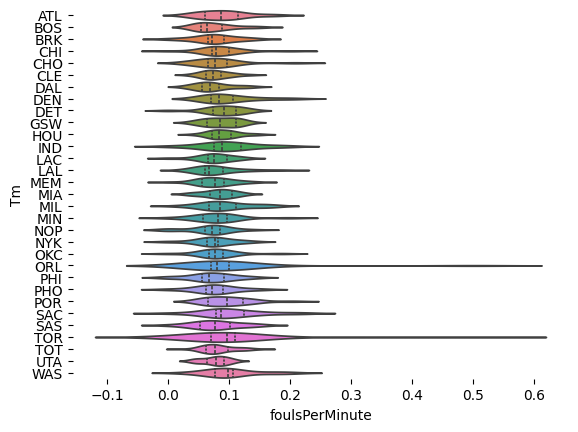

In [11]:
sns.violinplot(basketData, x='foulsPerMinute', y='Tm', inner='quart',hue='Tm')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

They all look reasonably similar. My hyperpriors (assuming the means and variance are from the same distributions) will probably work well since all the distributions are so similar. It also makes sense that teams are usualy a (semi) random collection of players so they should all be relatively similar.

I don't think my priors are bad based on the actual data.

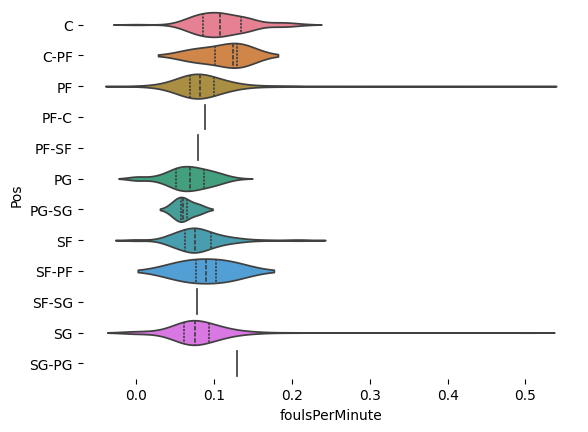

In [12]:
sns.violinplot(basketData, x='foulsPerMinute', y='Pos', inner='quart',hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

I'd say this is a fine match with my priors. I assumed the variability for everything is high so them being weird shapes is fine. I'm going to remove PF-C, PF-SF, SF-SG, and SG-PG since they seem to not have much data. The weird big lines are probably single players with low playtime so it's fine.

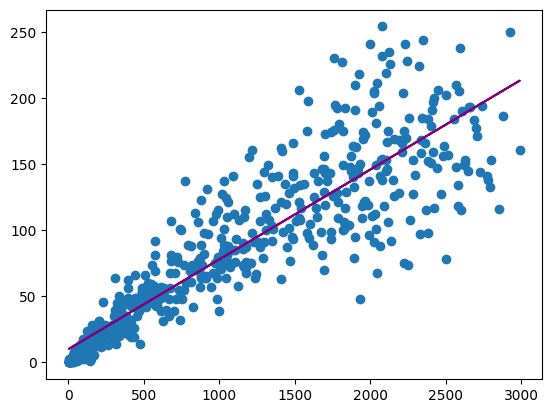

In [13]:
a, b = np.polyfit(basketData.MP, basketData.PF, 1) # syntax for linear regression taken from https://www.statology.org/line-of-best-fit-python/
c,d,e = np.polyfit(basketData.MP, basketData.PF, 2)
plt.scatter(basketData.MP, basketData.PF)
plt.plot(basketData.MP, b + a * basketData.MP, color='purple')

This doesn't have much to do with what I'm doing but is a nice visualization. The data is almost linear, which is what a Poisson distribution would predict.

In [14]:
basketDataF = basketData.query('Pos != \'PF-C\' and Pos != \'PF-SF\' and Pos != \'SF-SG\' and Pos != \'SG-PG\'') # removing bad postions

In [15]:
pos_idx = basketDataF.Pos.cat.remove_categories(['PF-C','PF-SF','SF-SG','SG-PG']).cat.codes.values # setting up this stuff

pos_codes = basketDataF.Pos.cat.remove_categories(['PF-C','PF-SF','SF-SG','SG-PG']).cat.categories


basketCoords = {'pos':pos_codes}
####
tm_idx = basketData.Tm.cat.codes.values

tm_codes = basketData.Tm.cat.categories


basketCoords2 = {'tm':tm_codes}

print(basketCoords2) # printing positions and teams
print(basketCoords)

{'tm': Index(['ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
       'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'TOT', 'UTA',
       'WAS'],
      dtype='object')}
{'pos': Index(['C', 'C-PF', 'PF', 'PG', 'PG-SG', 'SF', 'SF-PF', 'SG'], dtype='object')}


## Likelihood

Like I said before, I'm first going to try a poisson for my likelihood. Poisson distributions measure the amount of times an event happens in a certain time frame based on a rate so this is perfect for my likelihood. My data just measures how often people foul in a certain time frame. I will have to multiply the Poisson paramater by playtime so the rate can be normalized.

Basically, I'm saying somebody with 10x as much playtime will foul 10x as much. This also works out mathamatically because poisson(mu) + poisson(mu) = poisson(2mu). Do this for each minute to get poisson(minutes played * mu).

## Position Model

Below is a model using a Poisson likelihood (as described) and all the priors I detailed

In [ ]:
with pm.Model(coords = basketCoords) as basket_model: # I'll be honest, I'm using truncated normals because the model exploded with normal distributions
    # Hyper parameter
    #


    mu_p = pm.TruncatedNormal('mu_p', mu = .0833, sigma = .015, lower=0)


    # Parameter for positions
    θ = pm.TruncatedNormal('θ', sigma = .0175, mu = mu_p, lower=0, dims='pos')

    # Parameter for players. Idk where the name came from
    bet = pm.TruncatedNormal('bet', mu = θ[pos_idx], sigma = .02, lower=0)



    _ = pm.Poisson('gs',
                    mu = bet * basketDataF.MP.values, # guess of rate
                    observed = basketDataF.PF.values) # observed rate for each player

    idata_pos = pm.sample()

Output()

Output()

### Checking Likelihoods

array([[<Axes: title={'center': 'bet'}>, <Axes: title={'center': 'bet'}>],
       [<Axes: title={'center': 'mu_p'}>,
        <Axes: title={'center': 'mu_p'}>],
       [<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

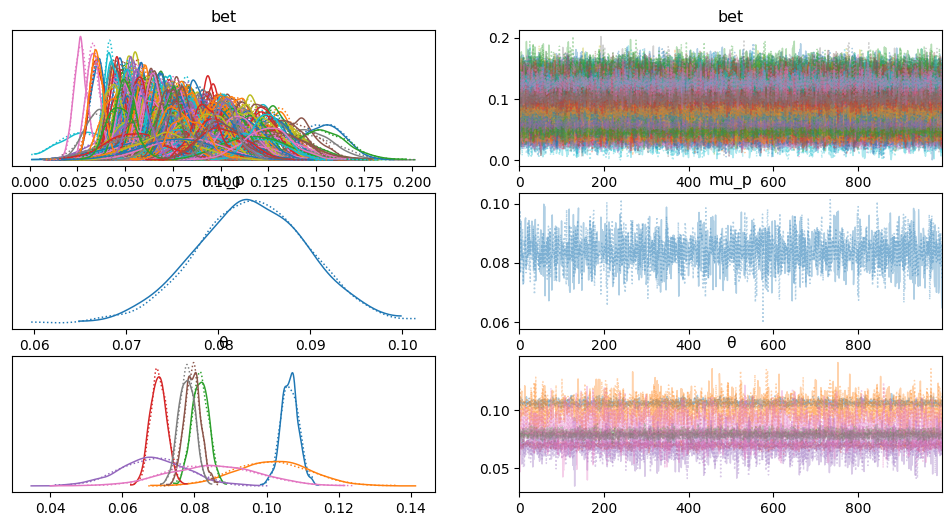

In [ ]:
az.plot_trace(idata_pos)

These seem to be reasonably good chains. The dotted line almost matches the line and 4 of the mean rate for position priors have low variability on the right part (it's just the orange, pink, and purple jumping all over the place).

In [ ]:
az.rhat(idata_pos)

<xarray.Dataset> Size: 9kB
Dimensions:    (bet_dim_0: 568, pos: 8)
Coordinates:
  * bet_dim_0  (bet_dim_0) int64 5kB 0 1 2 3 4 5 6 ... 562 563 564 565 566 567
  * pos        (pos) <U5 160B 'C' 'C-PF' 'PF' 'PG' 'PG-SG' 'SF' 'SF-PF' 'SG'
Data variables:
    bet        (bet_dim_0) float64 5kB 1.0 0.9997 1.007 ... 1.003 1.003 1.002
    mu_p       float64 8B 0.9994
    θ          (pos) float64 64B 1.001 0.9993 1.001 1.0 0.9992 1.0 1.0 1.002

Again, the rhat values look pretty good. Most are right above or right below 1.

array([<Axes: >], dtype=object)

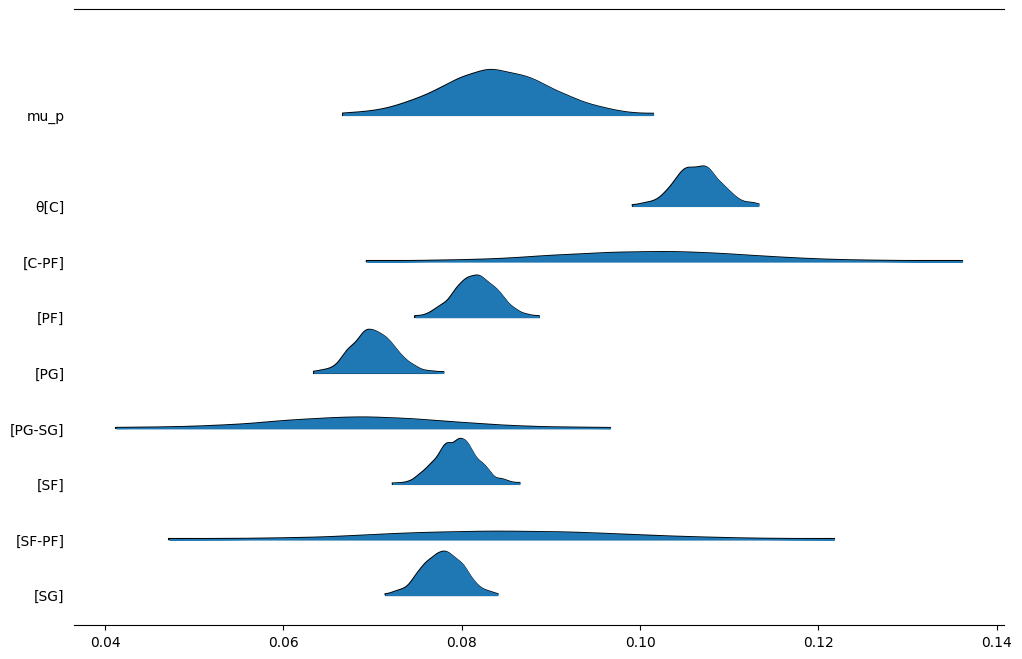

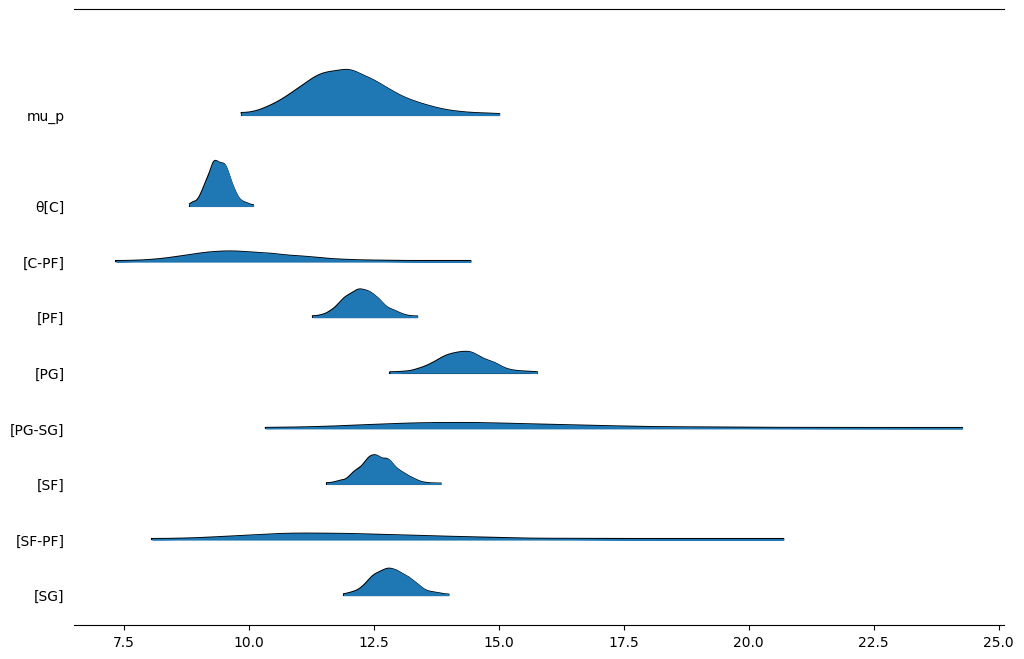

In [ ]:
def inverse(x): # this is just to see a graph of minutes per foul too
  return 1/x

az.plot_forest(idata_pos, var_names=['mu_p','θ'], combined=True, figsize=(12, 8), kind = 'ridgeplot', hdi_prob=0.998)
az.plot_forest(idata_pos, var_names=['mu_p','θ'], combined=True, figsize=(12, 8), kind = 'ridgeplot', hdi_prob=0.998, transform=inverse)

The top graph is fouls/minute and bottom is minutes/foul.

My model is fairly certain that centers foul the most. Compared to the other four main positions, centers foul a lot more. It's around 9.5 minutes per foul to 13.5 minutes per foul. It concludes the other main positions are about the same, though point guards likely foul the least.

Now, about those weird long ones. My initial guess was that they were more variable due to being the combination of multiple positions.

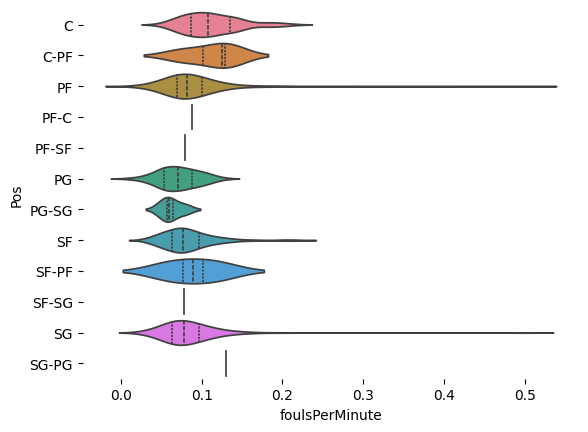

In [ ]:
sns.violinplot(basketData, x='foulsPerMinute', y='Pos', inner='quart',hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

Looking back at the data though, this isn't the case. The combined positions aren't more variable in the data.

It turns out there was just very little data in these positions.

The positions do have enough data and the data is normal enough though that the model works without problems. It's not like the goalkeeper position where everything got messed up (players playing multiple positions foul too).

**PPC**

Although I don't exactly care about the output of the ppc, it is still a good way to check if the model is accurate.

Output()

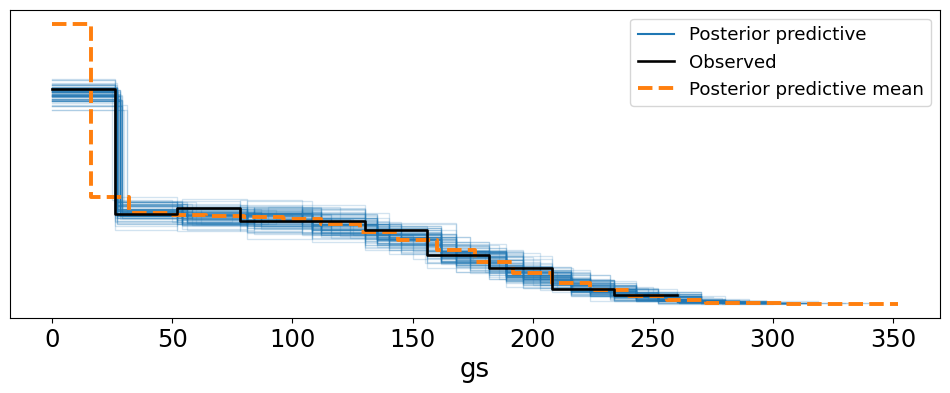

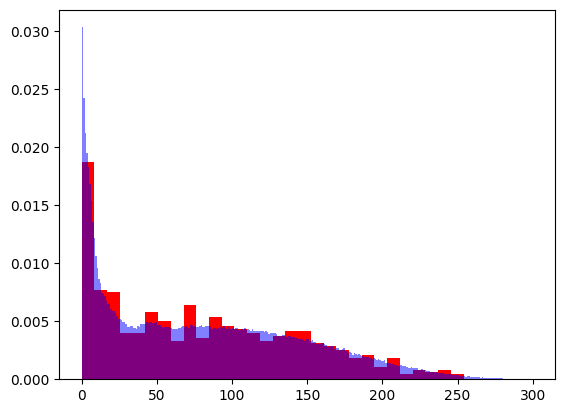

In [ ]:
pm.sample_posterior_predictive(idata_pos, model=basket_model, extend_inferencedata=True) # sampling from posterior
az.plot_ppc(idata_pos, num_pp_samples=100, figsize=(12, 4),) # plotting ppc

stacked_FT_2324 = az.extract(idata_pos, group="posterior_predictive") # getting predictions
samples = stacked_FT_2324.sel(sample=0).gs.to_series().values


sampFig = plt.figure() # plotting predictions vs data
ax = sampFig.add_subplot(111)
ax.hist(basketDataF.PF, density = True, bins=30, alpha=1, color='r')
ax.hist(samples, bins=300, density = True, alpha = .5, color='b', range=(0,300))


plt.show()

(red is data, blue is prediction)

The ppc looks fine. The initial peak is from people who just don't play much. They'll won't get many personal fouls since they don't play much. After the peak is a plateau. I'm guessing the plateau is from the playtime for players also plateauing. The short descent at the end is caused by players just not playing enough to foul enough.

With the good chains, good rhat values, good pcc, and good reason for a Poisson distribution, I think it is fair to say that this Poisson model is a good model of What is happening in reality.

In conclusion, centers are the biggest bullies in the NBA.

## Teams Likelihood

I just copy pasted most of the code for this. Nothing really new

This model is incredibly similar to the position one, expect is has the added sigma hyperparameter (explained in Priors section).

In [26]:
with pm.Model(coords = basketCoords2) as basket_modelT:
    # Hyper parameters
    #

    # Parameter for positions
    θ = pm.TruncatedNormal('θ', sigma = .0175, mu = .08, lower = 0, dims='tm')

    bet = pm.TruncatedNormal('bet', mu = θ[tm_idx], sigma = .02, lower=0)



    _ = pm.Poisson('gs',
                    mu = bet * basketData.MP.values, #guess of rate
                    observed = basketData.PF.values) # rate for each player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_tms = pm.sample(target_accept=.95)

Output()

Output()

Below is a non-hierarchical model. Same likelihood and priors excpet the hyperpriors were removed (parameters were changed to mean of hyper priors).

In [25]:
with pm.Model(coords = basketCoords2) as basket_modelT2:
    # Hyper parameters
    #


    mu_p = pm.TruncatedNormal('mu_p', mu = .08, sigma = .01, lower=0)
    sig_p = pm.TruncatedNormal('sig_p', mu=.0175, sigma = .003, lower=0) # this goes close to 0 sometimes and then breaks everything

    # Parameter for positions
    θ = pm.TruncatedNormal('θ', sigma = sig_p, mu = mu_p, lower = 0, dims='tm')

    bet = pm.TruncatedNormal('bet', mu = θ[tm_idx], sigma = .02, lower=0)



    _ = pm.Poisson('gs',
                    mu = bet * basketData.MP.values, #guess of rate
                    observed = basketData.PF.values) # rate for each player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_tms2 = pm.sample(target_accept=.95)

Output()

Output()

Trace for hierarchical model:

array([[<Axes: title={'center': 'bet'}>, <Axes: title={'center': 'bet'}>],
       [<Axes: title={'center': 'mu_p'}>,
        <Axes: title={'center': 'mu_p'}>],
       [<Axes: title={'center': 'sig_p'}>,
        <Axes: title={'center': 'sig_p'}>],
       [<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

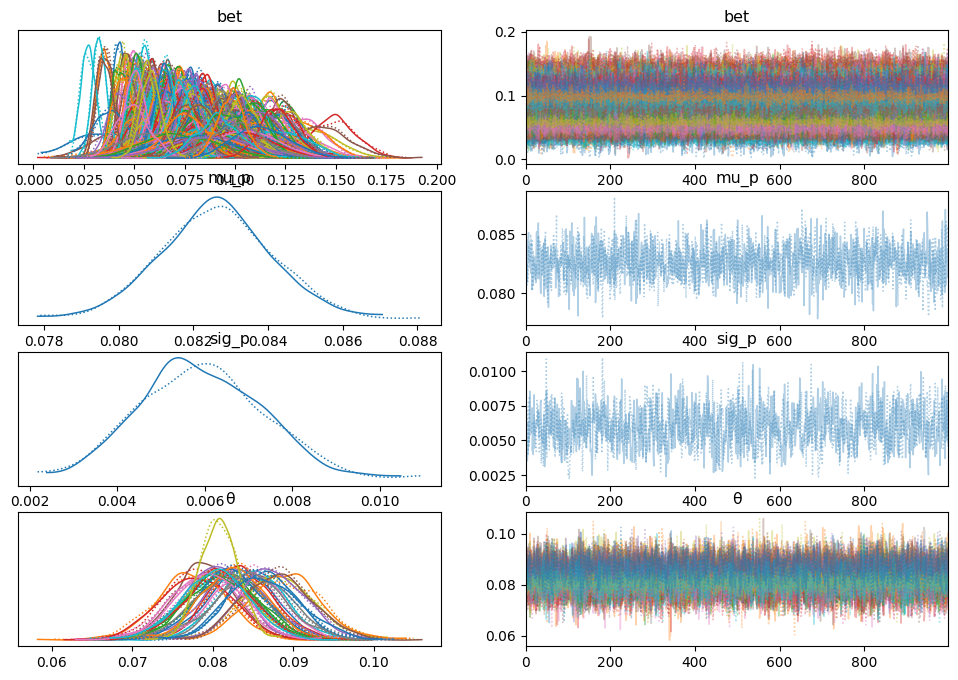

In [17]:
az.plot_trace(idata_tms2)

The chains for the sigma and mu hyperparameters look a bit off, but I would still say this is a reasonably good chain. It also kind of makes a rainbow for theta.

In [30]:
az.rhat(idata_tms2)

<xarray.Dataset> Size: 10kB
Dimensions:    (bet_dim_0: 572, tm: 31)
Coordinates:
  * bet_dim_0  (bet_dim_0) int64 5kB 0 1 2 3 4 5 6 ... 566 567 568 569 570 571
  * tm         (tm) <U3 372B 'ATL' 'BOS' 'BRK' 'CHI' ... 'TOR' 'TOT' 'UTA' 'WAS'
Data variables:
    bet        (bet_dim_0) float64 5kB 1.0 0.9998 1.007 ... 1.002 1.009 0.9999
    mu_p       float64 8B 1.0
    sig_p      float64 8B 1.0
    θ          (tm) float64 248B 1.001 0.9994 0.9996 0.9992 ... 1.002 1.0 0.9994

In [29]:
az.rhat(idata_tms)

<xarray.Dataset> Size: 10kB
Dimensions:    (bet_dim_0: 572, tm: 31)
Coordinates:
  * bet_dim_0  (bet_dim_0) int64 5kB 0 1 2 3 4 5 6 ... 566 567 568 569 570 571
  * tm         (tm) <U3 372B 'ATL' 'BOS' 'BRK' 'CHI' ... 'TOR' 'TOT' 'UTA' 'WAS'
Data variables:
    bet        (bet_dim_0) float64 5kB 1.006 1.001 0.9994 ... 1.0 0.9996 1.003
    θ          (tm) float64 248B 1.004 0.9998 1.003 1.0 ... 1.002 1.001 0.9999

(The hierarchical model is the top one)

The rhat values also look good. They are all close to one. There is also no signifacant difference between the hierarchical and non-hierarchical models.

In [19]:
def invert(num):
  return 1/num

Posteriors of the average fouls per minute for each team.

array([<Axes: >], dtype=object)

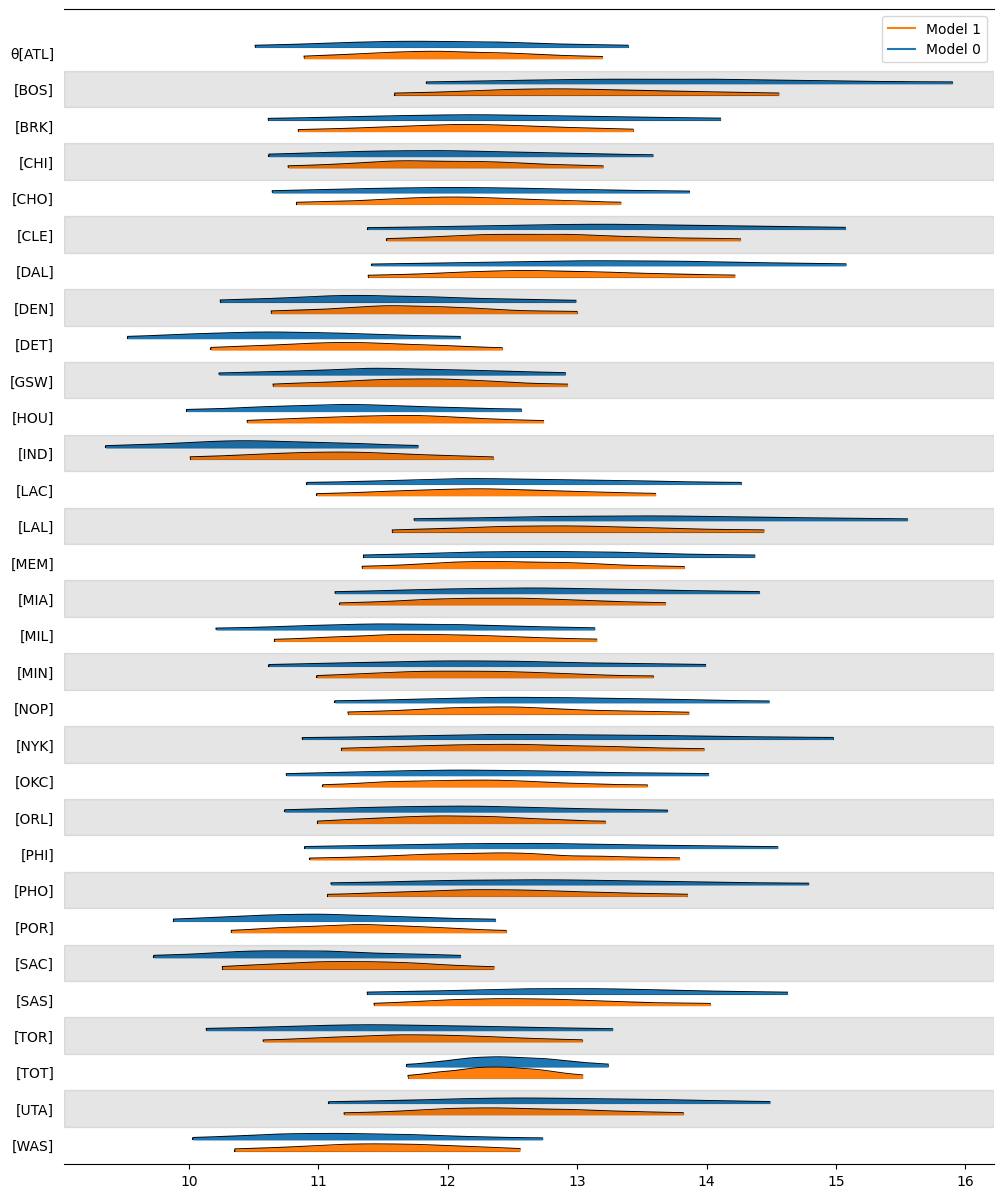

In [27]:
az.plot_forest([idata_tms,idata_tms2], var_names = ['θ'], combined=True, figsize=(12, 15), kind = 'ridgeplot', transform=invert)  # transform=invert makes the data change units (fouls/minute to minutes/foul)

Posteriors for the minutes per foul for each time. (orange is, of course, the hierarchical model)

Description of just the hierarchical posteriors:

All teams seem to have reasonably close posteriors, all of them sharing some overlap. There is no team which I could claim definitely fouls more than others. There also seems to exist a great variability in teams. Although teams may have their own play style as a team, individual still have their own playstyle so the model gets confused on the true mean.

On that note though, Indiana and Detroit seem to foul the most. The Lakers seem to foul the least.

Comparing the models:

As expected, the hierarchical model is closer to a central mean and is less variable. Most of the teams still have overlapping distributions of their means so the outcome isn't too different. I'd say the hierarchical model is fine to use in this case because there does seem to be a central value that all the teams are tending towards.

Output()

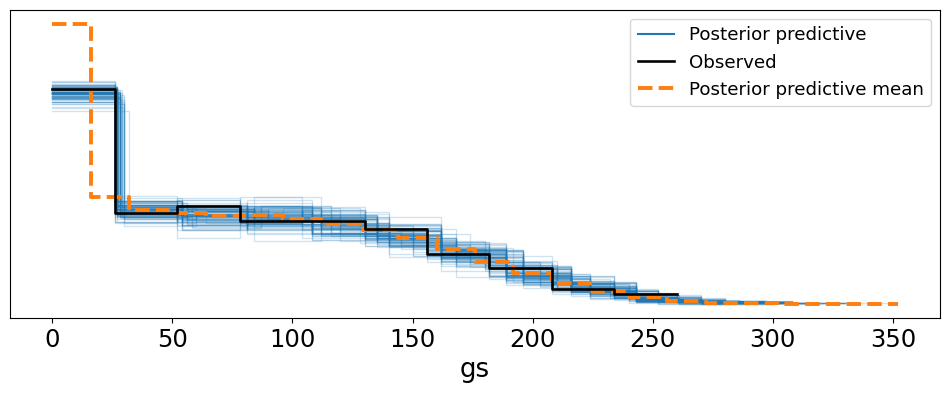

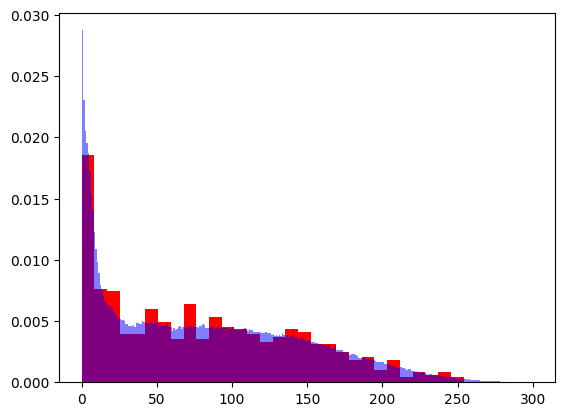

In [23]:
pm.sample_posterior_predictive(idata_tms2, model=basket_modelT2, extend_inferencedata=True) # getting predicted samples
az.plot_ppc(idata_tms2, num_pp_samples=100, figsize=(12, 4),) # plotting ppcc

stacked_FT_2324 = az.extract(idata_tms2, group="posterior_predictive") # getting predicted samples
samples = stacked_FT_2324.sel(sample=0).gs.to_series().values


sampFig = plt.figure() # plotting histogram
ax = sampFig.add_subplot(111)
ax.hist(basketData.PF, density = True, bins=30, alpha=1, color='r')
ax.hist(samples, bins=300, density = True, alpha = .5, color='b', range=(0,300))


plt.show()

The ppc looks good again. Not much more to say since it looks the same as the ppc for positions.

# Conclusion

A poisson distribution seemed to be a good choice. Everything ran smoothly (once I got the syntax working) and the model seemed to be a good predictor. I think this model is sufficient because it both models the data well and has a good justification in reality. Players fouling is a random event which happens in a period of time so it follows a Poisson distribution.

Players fouling in basketball does seem to follow a poisson distrubtion. On average, players foul once every 12 minutes. Centers foul the most out of all postitions and there is no significant difference between teams.